In [2]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


cifar_train = CIFAR10(root="./data", train=True, download=True)
cifar_test = CIFAR10(root="./data", train=False, download=True)


def augument(train_dataset, test_dataset, batch_size=64):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    mean_R = cifar_train.data[:, :, :, 0].mean() / 255
    mean_G = cifar_train.data[:, :, :, 1].mean() / 255
    mean_B = cifar_train.data[:, :, :, 2].mean() / 255
    stddev_R = cifar_train.data[:, :, :, 0].std() / 255
    stddev_G = cifar_train.data[:, :, :, 1].std() / 255
    stddev_B = cifar_train.data[:, :, :, 2].std() / 255

    img_size = 32

    transform_train = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.RandomVerticalFlip(),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
            transforms.Normalize(
                mean=[mean_R, mean_G, mean_B], std=[stddev_R, stddev_G, stddev_B]
            ),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.CenterCrop(img_size),
            transforms.Normalize(
                mean=[mean_R, mean_G, mean_B], std=[stddev_R, stddev_G, stddev_B]
            ),
        ]
    )

    train_loader.dataset.transform = transform_train
    test_loader.dataset.transform = transform_test

    return train_loader, test_loader


train_loader, test_loader = augument(cifar_train, cifar_test)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
def patch_image_batch(image_batch, patch_size=16):
    assert image_batch.dim() == 4
    assert image_batch.shape[2] == image_batch.shape[3]

    height = image_batch.shape[2]
    width = image_batch.shape[3]

    assert height % patch_size == 0
    assert width % patch_size == 0

    max_i = height // patch_size
    max_j = width // patch_size
    seqs = []
    for img in image_batch:
        seq = []
        for i in range(max_i):
            for j in range(max_j):
                seq.append(
                    img[
                        :,
                        i * patch_size : (i + 1) * patch_size,
                        j * patch_size : (j + 1) * patch_size,
                    ]
                )
        img_seq = torch.stack(seq)
        seqs.append(img_seq)
    batch_seq = torch.stack(seqs)
    return batch_seq

torch.Size([256, 3, 32, 32])
torch.Size([256, 64, 3, 4, 4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

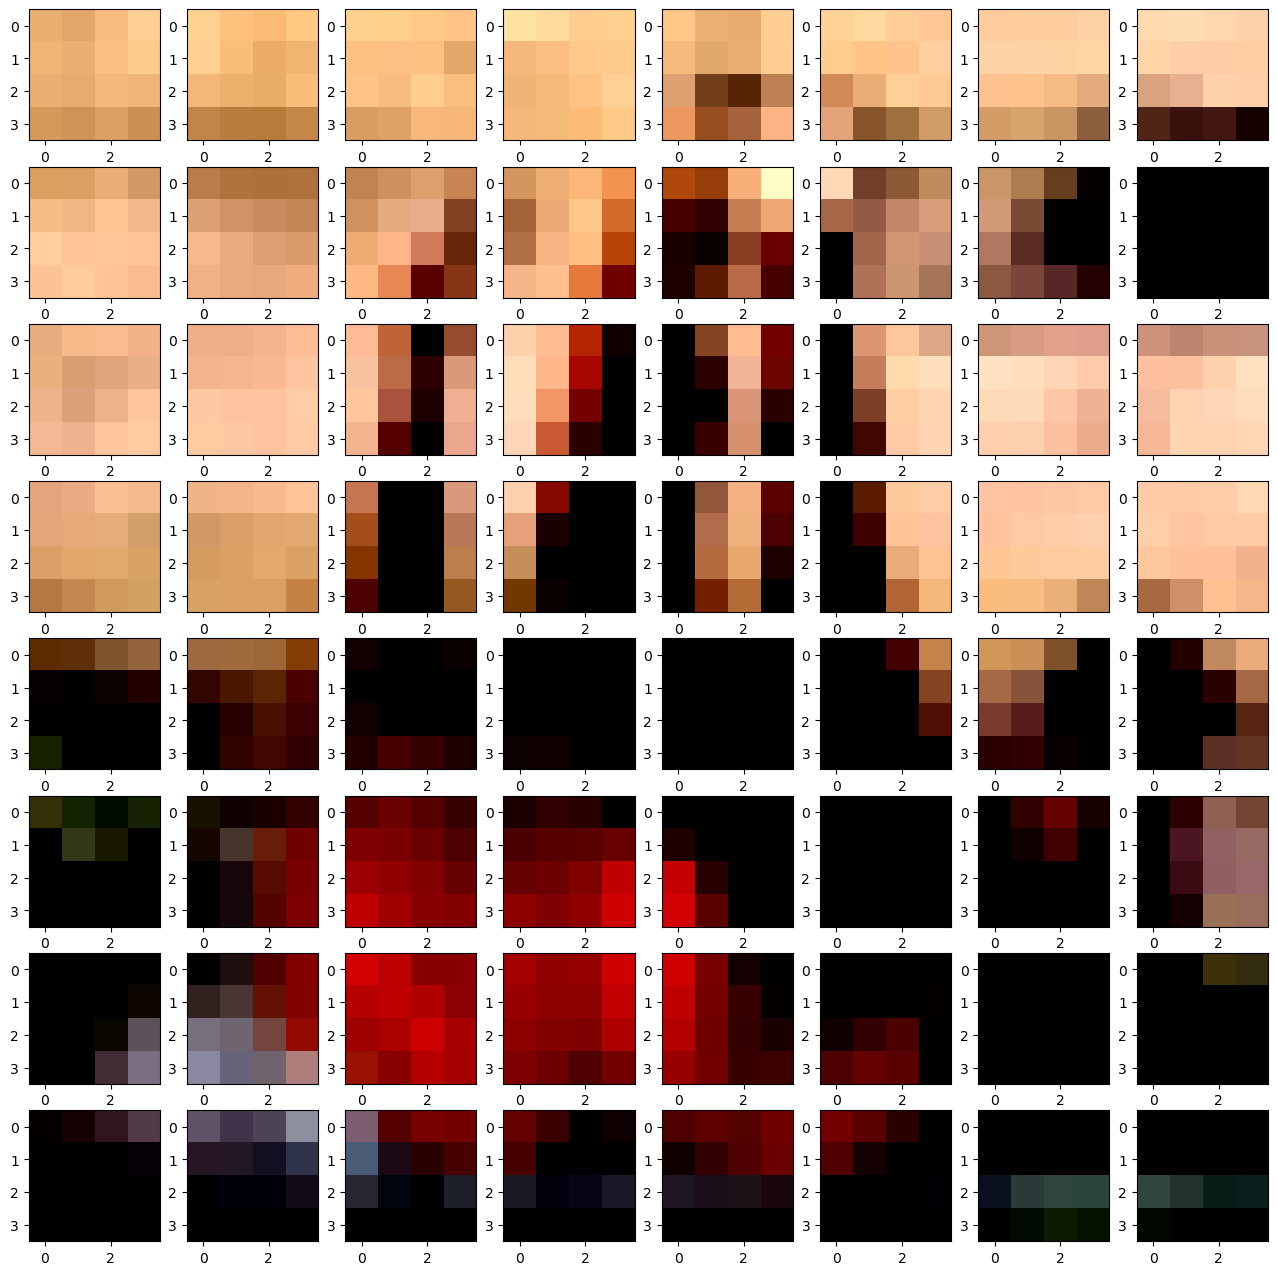

In [8]:
for val, label in train_loader:
    print(val.shape)
    res = patch_image_batch(val, patch_size=4)
    print(res.shape)
    break


fig, ax = plt.subplots(8, 8, figsize=(16, 16))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(res[0, i * 8 + j].permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


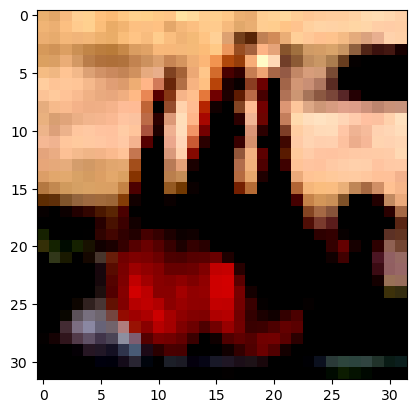

In [9]:
plt.imshow(val[0].permute(1, 2, 0))

In [4]:
class FeedForward(nn.Module):
    def __init__(self, outer_dim, hidden_dim, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(outer_dim),
            nn.Linear(outer_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, outer_dim),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)


class Transformer(nn.Module):
    def __init__(self, in_dim, hidden_dim, dropout=0.2, num_heads=8, num_layers=6):
        super().__init__()

        self.layers = nn.ModuleList(
            [
                nn.ModuleList(
                    [
                        nn.MultiheadAttention(
                            embed_dim=in_dim, num_heads=num_heads, dropout=dropout
                        ),
                        FeedForward(in_dim, hidden_dim, dropout),
                    ]
                )
                for _ in range(num_layers)
            ]
        )

    def forward(self, x):
        for attention, feedforward in self.layers:
            x = x + attention(x, x, x)[0]
            x = x + feedforward(x)
        return x


class VisualTransformer(nn.Module):
    def __init__(self, patch_size=4, embedded_dim=256, hidden_dim=512, dropout=0.2):
        super().__init__()
        self.patch_size = patch_size
        self.patch_len = 3 * patch_size * patch_size

        self.patch_embed = nn.Linear(self.patch_len, embedded_dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, embedded_dim))
        self.positional_encoding = nn.Parameter(torch.randn(1, 1, embedded_dim))
        self.dropout = dropout

        self.transformer = Transformer(
            embedded_dim,
            hidden_dim=hidden_dim,
            dropout=dropout,
            num_heads=8,
            num_layers=6,
        )
        self.layer_norm = nn.LayerNorm(embedded_dim)
        self.final_linear = nn.Linear(embedded_dim, 10)

    def forward(self, x):
        # print(f"Initial batch shape: {x.shape}")
        batch_size = x.shape[0]
        patch_batch = patch_image_batch(x, patch_size=self.patch_size)

        # print(f"Patched batch shape: {patch_batch.shape}")
        patch_batch = nn.Flatten(2)(patch_batch)
        # print(f"Flattened patch batch shape: {patch_batch.shape}")

        embedded_patches = self.patch_embed(patch_batch)
        # print(f"Embedded patches shape: {embedded_patches.shape}")

        embedded_patches = torch.cat(
            [self.cls_token.repeat(batch_size, 1, 1), embedded_patches], dim=1
        )
        # print(f"Embedded patches with cls token shape: {embedded_patches.shape}")

        # positional encoding
        embedded_patches = embedded_patches + self.positional_encoding
        # print(
        # f"Embedded patches with positional encoding shape: {embedded_patches.shape}"
        # )

        # dropout
        embedded_patches = nn.Dropout(self.dropout)(embedded_patches)

        # transformer
        output = self.transformer(embedded_patches)
        # print(f"Output shape: {output.shape}")

        # get only class token
        output = output[:, 0, :]

        # layer norm
        output = self.layer_norm(output)
        output = self.final_linear(output)
        return output

In [5]:
from time import time

model = VisualTransformer().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
learning_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=[100, 150],
    gamma=0.1,
)


for epoch in range(160):
    start = time()
    losses = []
    for i, (val, label) in enumerate(train_loader):
        optimizer.zero_grad()
        val, label = val.to(device), label.to(device)
        output = model(val)
        label = F.one_hot(label, 10).to(torch.float32)
        loss = loss_fn(output, label)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        batch_size = val.shape[0]
        total_completed = (i + 1) * batch_size
        total = len(train_loader.dataset)
        print(
            "Epoch %d batch %d %.2f%%" % (epoch, i, 100 * total_completed / total),
            end="\r",
        )

    learning_scheduler.step()

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/model_{epoch}.pth")
        losses = []
        total_right = 0
        total = 0
        for val, label in test_loader:
            val, label = val.to(device), label.to(device)
            output = model(val)
            label = F.one_hot(label, 10).to(torch.float32)
            loss = loss_fn(output, label)
            losses.append(loss.item())
            total_right += (output.argmax(dim=1) == label.argmax(dim=1)).sum().item()
            total += val.shape[0]
        print("Epoch %d \ttest loss: %.4f\ttest accuracy: %.4f%%" % (epoch, np.mean(losses), total_right / total * 100))

    stop = time()
    print("Epoch %d \tloss: %.4f\ttime: %.2f" % (epoch, np.mean(losses), stop - start))

/home/mjste/miniconda3/envs/mro/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch 0 	test loss: 2.3303	test accuracy: 9.9400%
Epoch 0 	loss: 2.3303	time: 360.58
Epoch 1 	loss: 2.3176	time: 318.81
Epoch 2 	loss: 2.3120	time: 241.42
Epoch 3 	loss: 2.3094	time: 241.43
Epoch 4 	loss: 2.3068	time: 241.44
Epoch 5 	loss: 2.3060	time: 241.51
Epoch 6 	loss: 2.3044	time: 241.39
Epoch 7 	loss: 2.3042	time: 241.46
Epoch 8 	loss: 2.3037	time: 241.52
Epoch 9 	loss: 2.3035	time: 241.52
Epoch 10 	test loss: 2.3025	test accuracy: 9.7100%
Epoch 10 	loss: 2.3025	time: 263.36
Epoch 11 	loss: 2.3028	time: 241.41
Epoch 12 	loss: 2.3027	time: 241.44
Epoch 13 	loss: 2.3028	time: 241.44
Epoch 14 	loss: 2.3027	time: 241.43
Epoch 15 	loss: 2.3028	time: 312.03
Epoch 16 	loss: 2.3027	time: 330.98
Epoch 17 	loss: 2.3027	time: 250.44
Epoch 18 	loss: 2.3028	time: 241.39
Epoch 19 	loss: 2.3027	time: 241.43
Epoch 20 	test loss: 2.3027	test accuracy: 9.9300%
Epoch 20 	loss: 2.3027	time: 263.31
Epoch 21 	loss: 2.3026	time: 241.38
Epoch 22 	loss: 2.3027	time: 241.50
Epoch 23 	loss: 2.3026	time: 2

[10, 20]